In [ ]:
!git clone https://github.com/rasbt/deeplearning-models



Cloning into 'deeplearning-models'...
remote: Enumerating objects: 1463, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1463 (delta 87), reused 153 (delta 78), pack-reused 1293
Receiving objects: 100% (1463/1463), 42.57 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (719/719), done.
Updating files: 100% (252/252), done.


In [ ]:
%cd deeplearning-models/pytorch_ipynb/cnn/

/content/deeplearning-models/pytorch_ipynb/cnn


In [ ]:
import sys


# From local helper files
from torch.utils.data import DataLoader
from helper_utils import set_all_seeds, set_deterministic
from helper_evaluate import compute_confusion_matrix, compute_accuracy
# from helper_train import train_classifier_simple_v2
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_data import get_dataloaders_cifar10, UnNormalize
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from helper_evaluate import compute_accuracy
from helper_evaluate import compute_epoch_loss

import time
import torch
import torch.nn.functional as F

from collections import OrderedDict
import json
import subprocess
import sys
import xml.etree.ElementTree


In [ ]:
import sys
sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

# From local helper files
from helper_utils import set_all_seeds, set_deterministic
from helper_evaluate import compute_confusion_matrix, compute_accuracy
from helper_train import train_classifier_simple_v2
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_data import get_dataloaders_cifar10, UnNormalize

In [ ]:
%ls

cnn-alexnet-cifar10-grouped.ipynb       cnn-resnet34-celeba-dataparallel.ipynb
cnn-alexnet-cifar10.ipynb               cnn-resnet34-cifar10-pinmem.ipynb
cnn-allconv.ipynb                       cnn-resnet34-mnist.ipynb
cnn-basic.ipynb                         cnn-resnet34-quickdraw.ipynb
cnn-densenet121-cifar10.ipynb           cnn-resnet50-celeba-dataparallel.ipynb
cnn-densenet121-mnist.ipynb             cnn-resnet50-mnist.ipynb
cnn-embetter-mobilenet.ipynb            cnn-standardized.ipynb
cnn-he-init.ipynb                       cnn-vgg16-cats-dogs.ipynb
cnn-lenet5-cifar10.ipynb                cnn-vgg16-celeba-data-parallel.ipynb
cnn-lenet5-mnist.ipynb                  cnn-vgg16-celeba.ipynb
cnn-lenet5-quickdraw.ipynb              cnn-vgg16.ipynb
cnn-mobilenet-v2-cifar10.ipynb          cnn-vgg19.ipynb
cnn-mobilenet-v3-large-cifar10.ipynb    fc-to-conv.ipynb
cnn-mobilenet-v3-small-cifar10.ipynb    images/
cnn-resnet101-celeba.ipynb              nin-cifar10_batchnorm.ipynb
cnn-resnet101-c

In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 150
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [ ]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 170498071/170498071 [00:02<00:00, 80536775.52it/s]


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


In [ ]:
##########################
### MODEL
##########################


model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v3_small',
                       pretrained=False)

model.classifier[-1] = torch.nn.Linear(in_features=1024, # as in original
                                       out_features=10) # number of class labels in Cifar-10)

model = model.to(DEVICE)

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 001/060 | Batch 0000/0351 | Loss: 2.3036
Epoch: 001/060 | Batch 0100/0351 | Loss: 1.9202
Epoch: 001/060 | Batch 0200/0351 | Loss: 1.7110
Epoch: 001/060 | Batch 0300/0351 | Loss: 1.5785
Epoch: 001/060 | Train: 10.13% | Validation: 10.46% | Best Validation (Ep. 001): 10.46%
Time elapsed: 10.56 min
Epoch: 002/060 | Batch 0000/0351 | Loss: 1.3429
Epoch: 002/060 | Batch 0100/0351 | Loss: 1.4115
Epoch: 002/060 | Batch 0200/0351 | Loss: 1.3747
Epoch: 002/060 | Batch 0300/0351 | Loss: 1.2904
Epoch: 002/060 | Train: 50.75% | Validation: 50.46% | Best Validation (Ep. 002): 50.46%
Time elapsed: 21.11 min
Epoch: 003/060 | Batch 0000/0351 | Loss: 1.3028
Epoch: 003/060 | Batch 0100/0351 | Loss: 1.2069
Epoch: 003/060 | Batch 0200/0351 | Loss: 1.2326
Epoch: 003/060 | Batch 0300/0351 | Loss: 1.1728
Epoch: 003/060 | Train: 59.84% | Validation: 59.02% | Best Validation (Ep. 003): 59.02%
Time elapsed: 31.51 min
Epoch: 004/060 | Batch 0000/0351 | Loss: 1.1033
Epoch: 004/060 | Batch 0100/0351 | Loss:

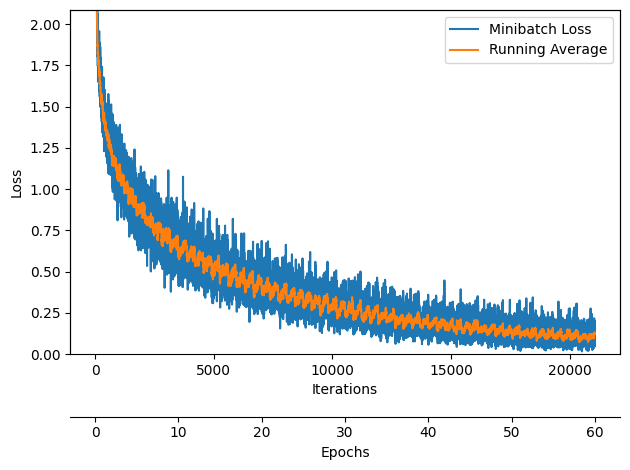

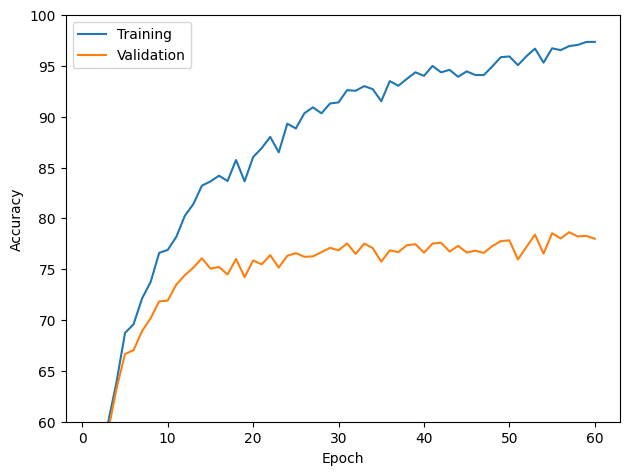

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

minibatch_loss_list, train_acc_list, valid_acc_list = train_classifier_simple_v2(
    model=model,
    num_epochs=60,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    best_model_save_path='mobilenet-v2-best-1.pt',
    device=DEVICE,
    scheduler_on='valid_acc',
    logging_interval=100)


plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=60,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()